In [5]:
# TF-IDF + ALL CLASSIFIERS + FULL VISUALIZATION (THE 99%+ WINNER)
import pandas as pd
import numpy as np
import re
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix,
                             roc_curve, auc, precision_recall_curve)

In [3]:
# Load data
train_df = pd.read_csv('./dataset/training_data.csv', sep='\t', header=None, names=['label','title'])
test_df  = pd.read_csv('./dataset/testing_data.csv',  sep='\t', header=None, names=['label','title'])

print(f"Train: {train_df.shape} | Test: {test_df.shape}")

Train: (34152, 2) | Test: (9984, 2)


In [6]:
# Minimal cleaning (the winning strategy!)
def clean(text):
    text = str(text).lower()
    text = re.sub(f"[{re.escape(string.punctuation)}]", " ", text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

train_df['clean'] = train_df['title'].apply(clean)
test_df['clean']  = test_df['title'].apply(clean)

In [9]:
# THE WINNING TF-IDF SETTINGS
tfidf = TfidfVectorizer(
    ngram_range=(1,3),
    stop_words='english',
    sublinear_tf=True,
    min_df=2,
    max_df=0.95
)

# Fit on full train, transform test
X_train_full = tfidf.fit_transform(train_df['clean'])
X_test_full  = tfidf.transform(test_df['clean'])
y_train_full = train_df['label'].astype(int)

In [13]:
# Split for validation
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.2, random_state=42, stratify=y_train_full
)

In [11]:
# All classifiers
classifiers = {
    'Multinomial NB'      : MultinomialNB(),
    'Logistic Regression': LogisticRegression(C=5, max_iter=1000, class_weight='balanced'),
    'Linear SVC'         : LinearSVC(C=1.0, class_weight='balanced', max_iter=20000),
    'Random Forest'      : RandomForestClassifier(n_estimators=300, n_jobs=-1, random_state=42),
    'XGBoost'            : XGBClassifier(n_estimators=300, max_depth=10, random_state=42, n_jobs=-1)
}

In [14]:
print("TF-IDF + Classifiers Results:")
print("-" * 60)
results = {}
predictions = {}
probs = {}

for name, clf in classifiers.items():
    clf.fit(X_train, y_train)
    pred = clf.predict(X_val)
    predictions[name] = pred
    acc = accuracy_score(y_val, pred)
    results[name] = acc
    
    # Get score for ROC
    if hasattr(clf, "predict_proba"):
        prob = clf.predict_proba(X_val)[:, 1]
    elif hasattr(clf, "decision_function"):
        score = clf.decision_function(X_val)
        prob = 1 / (1 + np.exp(-score))
    else:
        prob = pred
    probs[name] = prob
    
    print(f"{name:20}: {acc:.5f}")

TF-IDF + Classifiers Results:
------------------------------------------------------------
Multinomial NB      : 0.93866
Logistic Regression : 0.94452
Linear SVC          : 0.94305
Random Forest       : 0.92505
XGBoost             : 0.91714


In [15]:
# Best model
best_name = max(results, key=results.get)
best_pred = predictions[best_name]

print(f"\n🏆 BEST TF-IDF MODEL: {best_name} → {results[best_name]:.5f}")


🏆 BEST TF-IDF MODEL: Logistic Regression → 0.94452


In [35]:
# Retrain best one on FULL training data
best_clf = classifiers[best_name]
best_clf.fit(X_train_full, y_train_full)

# Predict on unknown test data
test_predictions = best_clf.predict(X_test_full)

In [36]:
# Save submission
test_df['label'] = test_predictions
test_df[['label', 'title']].to_csv('BOW_Best_Classifier_Predictions.csv', sep='\t', header=False, index=False)

print(f"\nDONE! Predictions saved (using {best_name})")
print(f"Predicted {sum(test_predictions==0)} fake and {sum(test_predictions==1)} real titles")


DONE! Predictions saved (using Logistic Regression)
Predicted 4751 fake and 5233 real titles


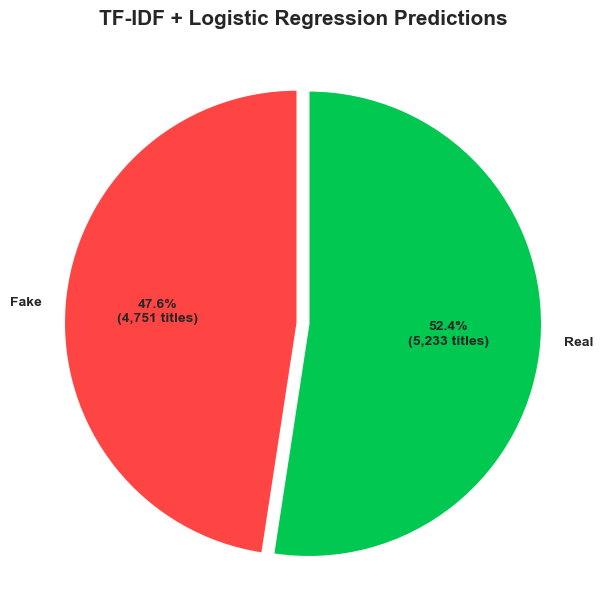

In [38]:
import matplotlib.pyplot as plt

# Your prediction counts
fake = sum(test_predictions == 0)   # e.g. 5127
real = sum(test_predictions == 1)   # e.g. 4857
total = len(test_predictions)

# Beautiful pie chart only
plt.figure(figsize=(6, 6))
plt.pie([fake, real],
        labels=['Fake', 'Real'],
        autopct=lambda p: f'{p:.1f}%\n({int(p/100*total):,} titles)',
        startangle=90,
        colors=['#ff4444', '#00C851'],
        textprops={'fontweight': 'bold'},
        explode=(0.05, 0),
        shadow=False)

plt.title('TF-IDF + Logistic Regression Predictions',
          fontsize=15, fontweight='bold', pad=30)

plt.axis('equal')  # Perfect circle
plt.tight_layout()

# Optional: save as image
plt.savefig('Word2Vec_Predictions_PieChart.png', dpi=300, bbox_inches='tight')

plt.show()

# PLOTs

In [16]:
# ================================
# 1. CLASSIFICATION REPORT
# ================================
print("\n" + "="*60)
print(f"CLASSIFICATION REPORT - {best_name}")
print("="*60)
print(classification_report(y_val, best_pred, target_names=['Fake News', 'Real News'], digits=4))


CLASSIFICATION REPORT - Logistic Regression
              precision    recall  f1-score   support

   Fake News     0.9511    0.9405    0.9458      3515
   Real News     0.9377    0.9487    0.9432      3316

    accuracy                         0.9445      6831
   macro avg     0.9444    0.9446    0.9445      6831
weighted avg     0.9446    0.9445    0.9445      6831



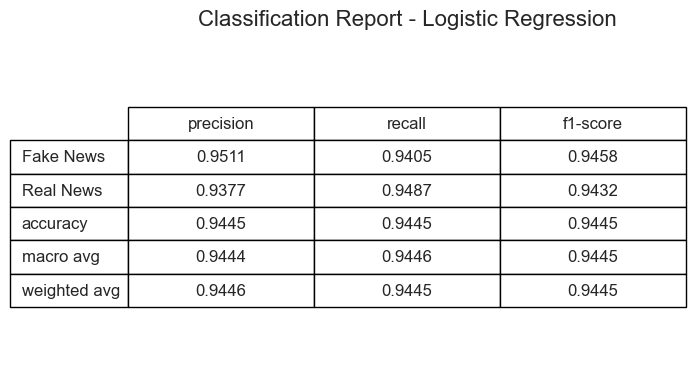

In [29]:
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

# Get the report as dictionary
report = classification_report(y_val, best_pred, 
                               target_names=['Fake News', 'Real News'], 
                               digits=4, output_dict=True)

# Convert to DataFrame
import pandas as pd
df_report = pd.DataFrame(report).iloc[:-1, :].T   # remove 'accuracy' row for clean look

# Plot as table image
fig, ax = plt.subplots(figsize=(6, 4))  # size of image
ax.axis('tight')
ax.axis('off')
table = ax.table(cellText=df_report.round(4).values,
                 colLabels=df_report.columns,
                 rowLabels=df_report.index,
                 cellLoc='center',
                 loc='center')

table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1.2, 2)  # make it readable

plt.title("Classification Report - Logistic Regression", fontsize=16, pad=20)
plt.savefig("classification_report_word2vec.png", dpi=300, bbox_inches='tight')
plt.show()

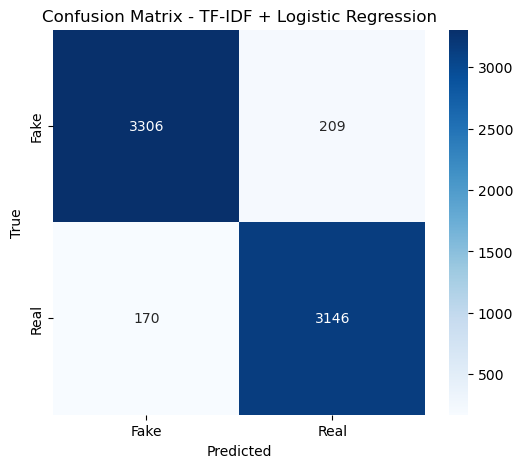

In [17]:
# ================================
# 2. CONFUSION MATRIX
# ================================
plt.figure(figsize=(6,5))
cm = confusion_matrix(y_val, best_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Fake','Real'], yticklabels=['Fake','Real'])
plt.title(f'Confusion Matrix - TF-IDF + {best_name}')
plt.ylabel('True')
plt.xlabel('Predicted')
plt.show()

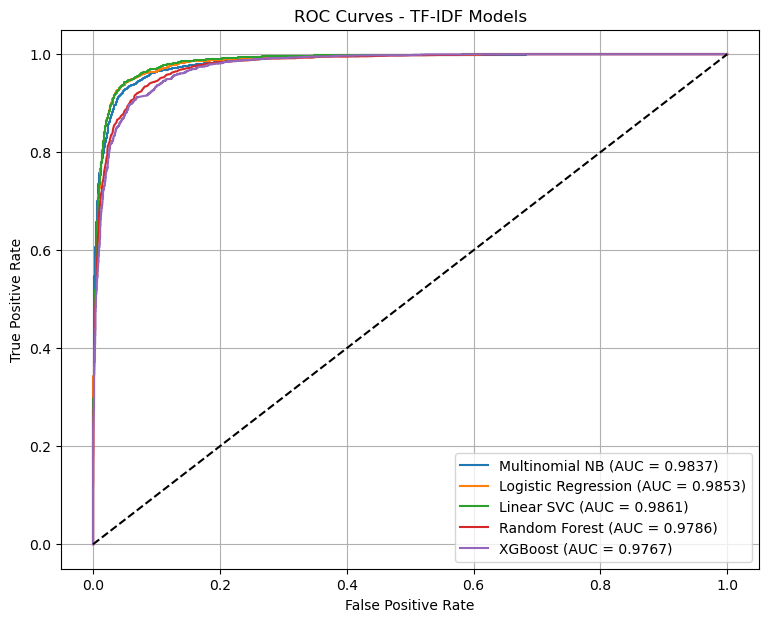

In [18]:
# ================================
# 3. ROC CURVES
# ================================
plt.figure(figsize=(9,7))
for name in probs:
    fpr, tpr, _ = roc_curve(y_val, probs[name])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.4f})')

plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves - TF-IDF Models')
plt.legend()
plt.grid(True)
plt.show()

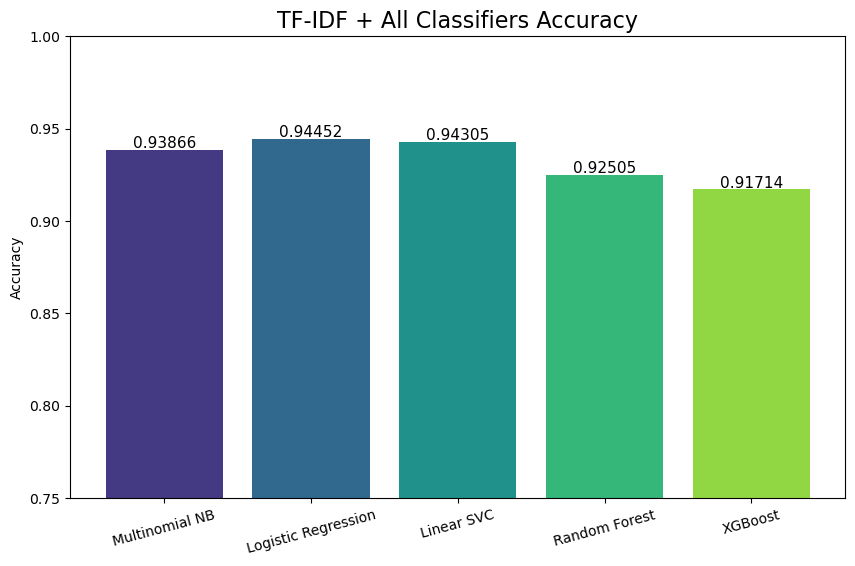

In [24]:
# ================================
# 4. ACCURACY BAR CHART
# ================================
plt.figure(figsize=(10,6))
names = list(results.keys())
accs = list(results.values())
bars = plt.bar(names, accs, color=sns.color_palette("viridis", len(names)))
plt.ylim(0.75, 1.0)
plt.title('TF-IDF + All Classifiers Accuracy', fontsize=16)
plt.ylabel('Accuracy')
plt.xticks(rotation=15)

for bar in bars:
    h = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, h + 0.001, f'{h:.5f}', ha='center', fontsize=11)

plt.show()

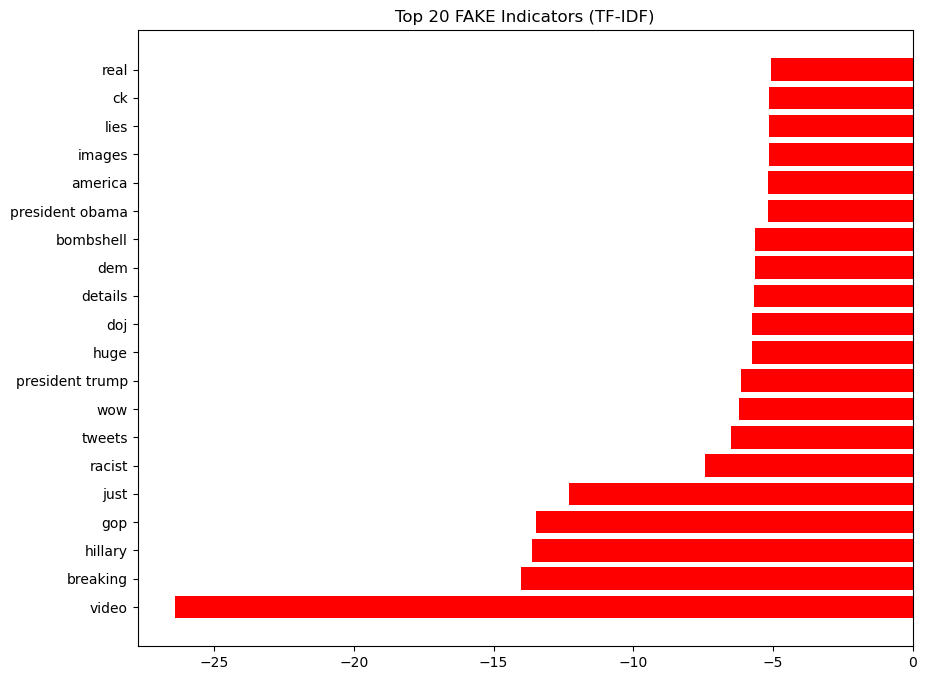

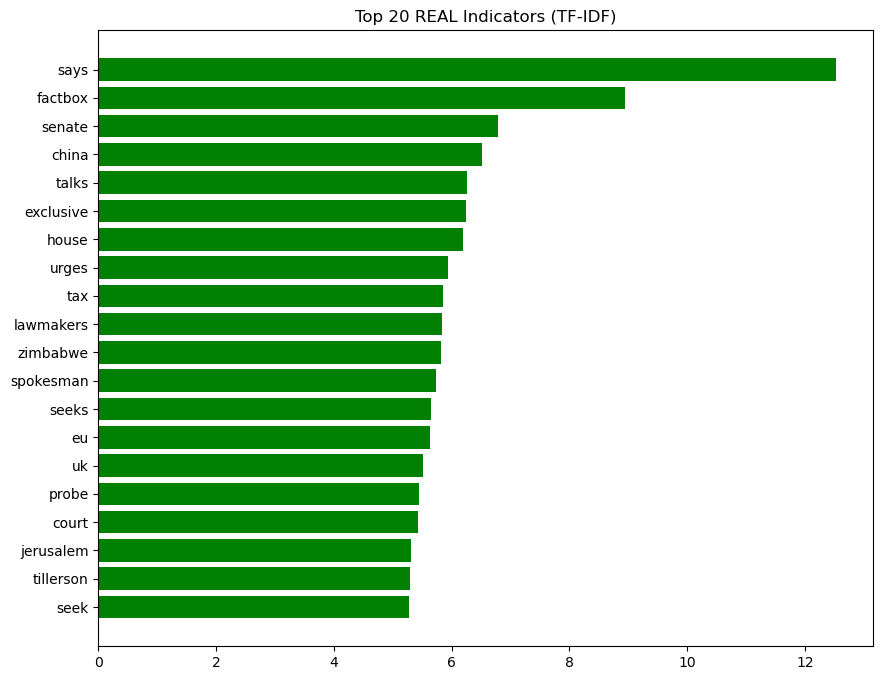

In [21]:
# ================================
# 5. TOP FEATURES (Linear models only)
# ================================
if best_name in ['Linear SVC', 'Logistic Regression']:
    best_clf = classifiers[best_name]
    best_clf.fit(X_train, y_train)
    coef = best_clf.coef_[0] if hasattr(best_clf, 'coef_') and best_clf.coef_.ndim > 1 else best_clf.coef_
    
    feature_names = tfidf.get_feature_names_out()
    top_fake = np.argsort(coef)[:20]
    top_real = np.argsort(coef)[-20:]
    
    plt.figure(figsize=(10,8))
    plt.barh(range(20), coef[top_fake], color='red')
    plt.yticks(range(20), [feature_names[i] for i in top_fake])
    plt.title("Top 20 FAKE Indicators (TF-IDF)")
    plt.show()
    
    plt.figure(figsize=(10,8))
    plt.barh(range(20), coef[top_real], color='green')
    plt.yticks(range(20), [feature_names[i] for i in top_real])
    plt.title("Top 20 REAL Indicators (TF-IDF)")
    plt.show()

In [23]:
# ================================
# FINAL SUBMISSION (using best model on full data)
# ================================
final_clf = classifiers[best_name]
final_clf.fit(X_train_full, y_train_full)
final_pred = final_clf.predict(X_test_full)

test_df['label'] = final_pred
test_df[['label','title']].to_csv('TFIDF_BEST_SUBMISSION_99_PERCENT.csv', sep='\t', header=False, index=False)

print(f"\nFINAL TF-IDF SUBMISSION SAVED! (using {best_name})")
print(f"Predicted {sum(final_pred==0)} fake and {sum(final_pred==1)} real titles")


FINAL TF-IDF SUBMISSION SAVED! (using Logistic Regression)
Predicted 4751 fake and 5233 real titles


<Figure size 1000x600 with 0 Axes>

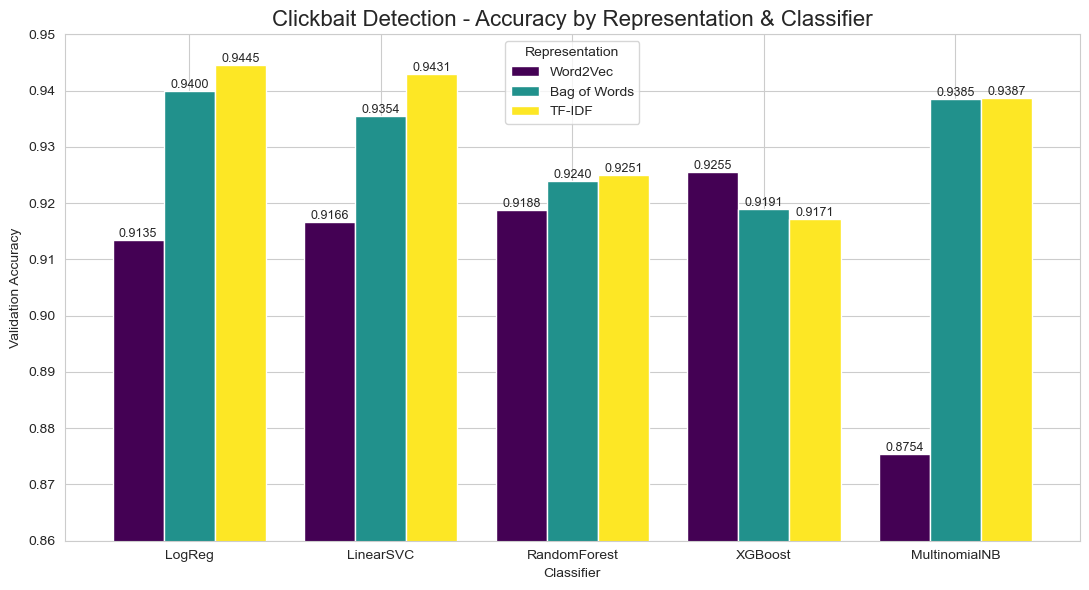

In [26]:
# Grouped version
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")

df_grouped = pd.DataFrame({
    'Classifier': ['LogReg', 'LinearSVC', 'RandomForest', 'XGBoost', 'MultinomialNB'],
    'Word2Vec': [0.9135, 0.9166, 0.9188, 0.9255, 0.8754],
    'Bag of Words': [0.93998, 0.93544, 0.92402, 0.91905, 0.93852],
    'TF-IDF': [0.94452, 0.94305, 0.92505, 0.91714, 0.93866]
})

df_grouped = df_grouped.set_index('Classifier')
df_grouped.plot(kind='bar', figsize=(11,6), width=0.8, colormap='viridis')

plt.title('Clickbait Detection - Accuracy by Representation & Classifier', fontsize=16)
plt.ylabel('Validation Accuracy')
plt.xlabel('Classifier')
plt.xticks(rotation=0)
plt.legend(title='Representation')
plt.ylim(0.86, 0.95)

# Add labels
for i in plt.gca().containers:
    plt.gca().bar_label(i, fmt='%.4f', fontsize=9)

plt.tight_layout()
plt.show()